In [1]:
#load Hansen and Senf & Seidl map
import geopandas as gpd

hansen = gpd.read_parquet('/Users/arthurcalvi/Repo/Disturbance-Attribution-Dataset-Joining/data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
senfseidl = gpd.read_parquet('/Users/arthurcalvi/Repo/Disturbance-Attribution-Dataset-Joining/data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet')
landespart = gpd.read_file('/Users/arthurcalvi/Repo/Disturbance-Attribution-Dataset-Joining/GoogleEarth/LandesPart.geojson').to_crs('EPSG:2154')

In [2]:
senfseidl = senfseidl[senfseidl['year'] >= 2001]
hansen['year'] = hansen['year'] + 2000
hansen = hansen[hansen['year'] <= 2020]

In [3]:
#create dataframe from total bounds of landespart
from shapely.geometry import Polygon
bounds = landespart.total_bounds
df = gpd.GeoDataFrame({'geometry': [Polygon([(bounds[0],bounds[1]), (bounds[0],bounds[3]), (bounds[2],bounds[3]), (bounds[2],bounds[1])])]}, crs='EPSG:2154')

In [7]:
hansen = hansen[ hansen['year'] >= 2015 ]
hansen_sub = hansen.clip(df)
hansen_sub = hansen_sub.clip(landespart)


/Users/arthurcalvi/Venv/Kayrros-default/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [4]:
senfseidl = senfseidl[ senfseidl.year >= 2015 ]
senfseidl_sub = senfseidl.clip(df)
senfseidl_sub = senfseidl_sub.clip(landespart)

/Users/arthurcalvi/Venv/Kayrros-default/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/arthurcalvi/Venv/Kayrros-default/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

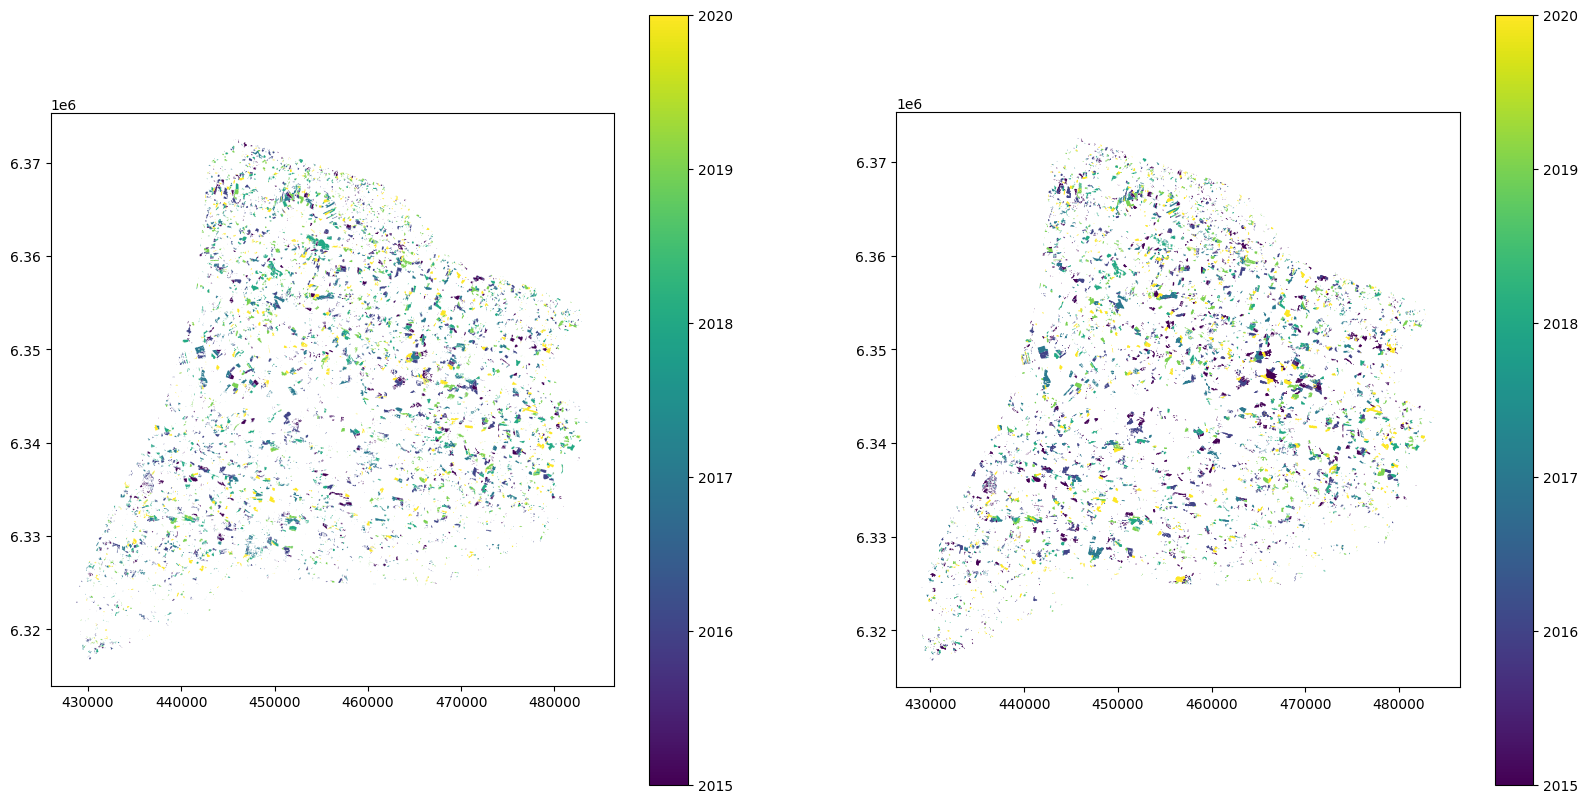

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
hansen_sub.plot(column='year', ax=axes[0], legend=True)
senfseidl_sub.plot(column='year', ax=axes[1], legend=True)

In [28]:
senfseidl_sub[['geometry', 'year']].to_parquet('senfseidl.parquet')

In [23]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

# Load your GeoDataFrame
gdf = hansen_sub

# Define the bounds of your raster
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
pixel_size = 30  # 30 meters

# Calculate the dimensions of the raster
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Define the transformation
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Define rasterize parameters
rasterize_params = {
    'shapes': ((geom, value) for geom, value in zip(gdf.geometry, gdf.year)),
    'out_shape': (height, width),
    'transform': transform,
    'fill': 0,  # fill value for 'nodata'
    'all_touched': True,
    'dtype': rasterio.int16
}

# Rasterize the GeoDataFrame
raster = rasterize(**rasterize_params)

# Write the raster to a file
with rasterio.open(
    'hansen.tif', 'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform,) as dst:
    dst.write(raster, 1)



In [5]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

# Load your GeoDataFrame
gdf = senfseidl_sub

# Define the bounds of your raster
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
pixel_size = 30  # 30 meters

# Calculate the dimensions of the raster
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Define the transformation
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Define rasterize parameters
rasterize_params = {
    'shapes': ((geom, value) for geom, value in zip(gdf.geometry, gdf.year)),
    'out_shape': (height, width),
    'transform': transform,
    'fill': 0,  # fill value for 'nodata'
    'all_touched': True,
    'dtype': rasterio.int16
}

# Rasterize the GeoDataFrame
raster = rasterize(**rasterize_params)

# Write the raster to a file
with rasterio.open(
    'senfseidl.tif', 'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform,) as dst:
    dst.write(raster, 1)



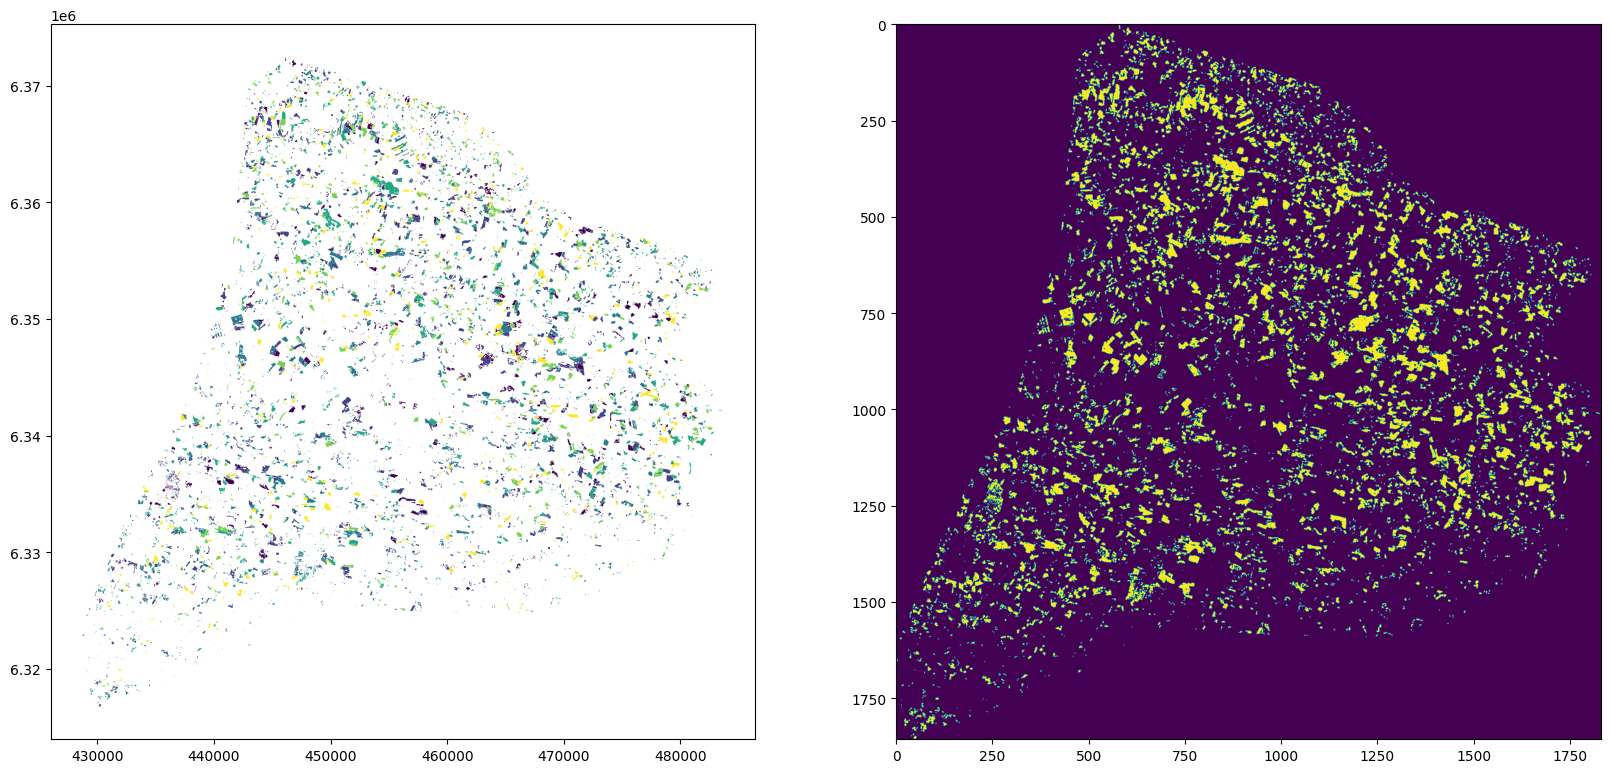

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
hansen_sub.plot(column='year', ax=axes[0], legend=False)
axes[1].imshow(raster)

In [7]:
import geopandas as gpd

gdf = gpd.read_parquet('../data/senfseidl.parquet')
gdf.to_csv('../data/senfseidl.csv')